# Generate pdb & h-bonds dataframes from pdb

### Imports

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import os
import csv
import time
import ast
import sys
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_rows', 200)

### Read in cmd line args

In [214]:
#sh macro_hbond.sh /Users/NikosMynhier/Desktop/David/Alpha_Psi_Calculation/fixed_pdbs_h 4 /Desktop/code/2021/AB-Fibril-Radius-vs-Hydrogen-Bond-Relationship /Users/NikosMynhier/Desktop/David/plots

args = sys.argv

#args: script name, /path/to/uncert_file.pdb, outfile path
args = ["script name", "/Users/davidboyer/Dropbox/Tau_Project_EISENBERG_LAB/amyloid_width/q_sayre/data/6lni_origin_5layers_h__Q__emd_0931_o.pdb", "/Users/davidboyer/Dropbox/Tau_Project_EISENBERG_LAB/amyloid_width/python/calculations/hbonds/data2/" ]
#"5w7v_3layers_neg120p44_h.pdb" #'6ufr_origin_5layers_h.pdb'
#args[1] = "/Users/NikosMynhier/Desktop/David/Alpha_Psi_Calculation/fixed_pdbs_h/5oqv_origin_5layers_h.pdb"


In [215]:
args

['script name',
 '/Users/davidboyer/Dropbox/Tau_Project_EISENBERG_LAB/amyloid_width/q_sayre/data/6lni_origin_5layers_h__Q__emd_0931_o.pdb',
 '/Users/davidboyer/Dropbox/Tau_Project_EISENBERG_LAB/amyloid_width/python/calculations/hbonds/data2/']

### Functions

$ \alpha = arccos( \frac{ ( V_1 \times V_2 ) \hspace{.1cm} \cdot \hspace{.1cm} ( V_2 \times V_3 ) }{\lvert V_1 \times V_2 \rvert \hspace{.1cm} \cdot \hspace{.1cm} \lvert V_2 \times V_3 \rvert} ) \hspace{.5cm}$
$V_n = (P_n \times P_{n+1})$

If the vectors u = (u1, u2, u3), v = (v1, v2, v3) and w = (w1, w2, w3) are vectors in 3-space with the
same initial point,

then they lie in the same plane if and only if

u(v x w) = 0

In [216]:
def get_file_length(input_file):
    with open(input_file) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def calc_dihedral(p1, p2, p3, p4):
    
    #get vectors from atom coordinates
    v1 = p2 - p1
    v2 = p3 - p2
    v3 = p4 - p3

    #cross vectors and normalize terms 
    c1 = np.cross(v1, v2)
    c1 = c1 / (c1 * c1).sum(-1)**0.5
    c2 = np.cross(v2, v3)
    c2 = c2 / (c2 * c2).sum(-1)**0.5
    
    #plug terms and get dihedral angle
    rad = np.arccos((c1*c2).sum(-1) / ((c1**2).sum(-1) * (c2**2).sum(-1))**0.5)
    
    #corrects sign if orthogonal vectors
    porm = np.sign((c1 * v3).sum(-1))
    if not porm == 0:
        rad = rad * porm

    return rad

def read_in_pdb_type1(path):
    input_file = open(f'{path}','r')
    file_length = get_file_length(f'{path}')
    
    atom = []
    atomno = []
    nama = []
    resn = []
    chainid = []
    resida = []
    xa = []
    ya = []
    za = []
    occup = []
    q_score = []
    elem = []
    charge = []
    for lines in range(file_length):
        line = input_file.readline()
        #line = str(line)
        if line[0:4] == 'ATOM':
            atom.append(line[0:6])
            atomno.append(line[6:11])
            nama.append(line[12:17])
            resn.append(line[17:20])
            chainid.append(line[21:22])
            resida.append(int(line[22:26]))
            xa.append(float(line[30:38]))
            ya.append(float(line[38:46]))
            za.append(float(line[46:54]))
            occup.append(line[54:60])
            #tempf.append(line[60:66])
            q_score.append(line[60:66])
            elem.append(line[76:78])
            charge.append(line[78:80])
    d = {'Atom': atom, 'Atom Number': atomno, 'Atom Name': nama, 'Residue Name': resn, 'Chain ID': chainid, 'Residue Number': resida, 'X': xa, 'Y': ya, 'Z': za, 'Occupancy': occup, 'Qscore': q_score, 'Element': elem, 'Charge': charge} 
    df = pd.DataFrame(d)
    input_file.close()
    return df

def read_in_pdb_type2(path):
    input_file = open(f'{path}','r')
    file_length = get_file_length(f'{path}')
    
    atom = []
    atomno = []
    nama = []
    resn = []
    chainid = []
    resida = []
    xa = []
    ya = []
    za = []
    occup = []
    q_score = []
    elem = []
    for lines in range(file_length):
        line = input_file.readline()
        if line[0:4] == 'ATOM':
            atom.append(line[0:6])
            atomno.append(line[6:11])
            nama.append(line[12:17])
            resn.append(line[17:20])
            chainid.append(line[21:22])
            resida.append(int(line[22:26]))
            xa.append(float(line[30:38]))
            ya.append(float(line[38:46]))
            za.append(float(line[46:54]))
            occup.append(line[54:60])
            q_score.append(line[60:66])
            elem.append(line[76:78])
    d = {'Atom': atom, 'Atom Number': atomno, 'Atom Name': nama, 'Residue Name': resn, 'Chain ID': chainid, 'Residue Number': resida, 'X': xa, 'Y': ya, 'Z': za, 'Occupancy': occup, 'Qscore': q_score, 'Element': elem} 
    df = pd.DataFrame(d)
    input_file.close()
    return df

### Read-in .pdb file

In [217]:
filename =  args[1]
sample_name = args[1].split("/")[-1][0:4]
outpath = args[2]
make_outpath = f" mkdir -p {outpath} "
os.system(make_outpath)
df = read_in_pdb_type2(filename)
df_uncert = df

In [218]:
Residue_subgroup_col = [1]
Residue_subgroup = 1
for i in range(1, len(df["Residue Number"])):
    if (df["Residue Number"][i] - df["Residue Number"][i-1]) > 1:
        Residue_subgroup += 1
    Residue_subgroup_col.append(Residue_subgroup)
df["subgroup"] = Residue_subgroup_col

### Calculations

____
Dihedral angles
___

φ (phi) involves the backbone atoms C-N-Cα-C

ψ (psi) involves the backbone atoms N-Cα-C-N

In [219]:
#Get Psi angles
Res_num, ψ_angles = 0, []
index1 = []
subgroup = 1
N1 = np.array([ df['X'][0], df['Y'][0], df['Z'][0] ])
for i in range(len(df)):
    if df['Residue Number'][i] != Res_num:
        if 'N' in df['Atom Name'][i]:
            N2 = np.array([ df['X'][i], df['Y'][i], df['Z'][i] ])
            if set(N2).difference(set(N1)) != set():
                alpha = calc_dihedral(N1,Ca,C1,N2)
                ψ_angles.append([Ca_index, alpha*180/np.pi])
                if df["subgroup"][i] != subgroup:
                    ψ_angles.pop()
                    ψ_angles.append([Ca_index, None])
                    subgroup += 1
                index1.append(i)
            N1 = np.array([ df['X'][i], df['Y'][i], df['Z'][i] ])
            Ca = np.array([ df['X'][i+1], df['Y'][i+1], df['Z'][i+1] ])
            C1 = np.array([ df['X'][i+2], df['Y'][i+2], df['Z'][i+2] ])
            Ca_index = i + 1
        Res_num = df['Residue Number'][i]

ψ_col = [None for i in range(len(df))]
for i in range(len(ψ_col)):
    for j in range(len(ψ_angles)):
        if i == ψ_angles[j][0]:
            ψ_col[i] = ψ_angles[j][1]
        
df['ψ Angle'] = ψ_col
index1_set = set(index1)

In [220]:
#Get Phi angles
Res_num, φ_angles= 0, []
index2 = []
subgroup = 1
C1 = np.array([ df['X'][2], df['Y'][2], df['Z'][2] ])
for i in range(len(df)):
        if df['Residue Number'][i] != Res_num:
            if 'N' in df['Atom Name'][i]:
                N1 = np.array([ df['X'][i], df['Y'][i], df['Z'][i] ])
                Ca = np.array([ df['X'][i+1], df['Y'][i+1], df['Z'][i+1] ])
                C2 = np.array([ df['X'][i+2], df['Y'][i+2], df['Z'][i+2] ])
                if set(C2).difference(set(C1)) != set():
                    Ca_index = i + 1
                    alpha = calc_dihedral(C1,N1,Ca,C2)
                    if df["subgroup"][i] == subgroup:
                        φ_angles.append([Ca_index, alpha*180/np.pi])
                    else:
                        φ_angles.append([Ca_index, None])
                        subgroup += 1
                    index2.append(i)
                C1 = np.array([ df['X'][i+2], df['Y'][i+2], df['Z'][i+2] ])
            Res_num = df['Residue Number'][i]     
        
        
φ_col = [None for i in range(len(df))]
for i in range(len(φ_col)):
    for j in range(len(φ_angles)):
        if i == φ_angles[j][0]:
            φ_col[i] = φ_angles[j][1]
df['φ Angle'] = φ_col
index2_set = set(index2)

In [221]:
#Get uncertainties angles
Res_num, uncert_col, uncert_values = 0, [], []
min_uncert = .01 #angstroms
for i in range(len(df_uncert)):
    if df_uncert['Residue Number'][i] != Res_num:
        if 'N' in df_uncert['Atom Name'][i]:
            #uncert_multiplier = np.array( float(df_uncert['Qscore'][i]) + float(df_uncert['Qscore'][i+3]) )
            uncert_multiplier = np.array( np.sqrt(float(df_uncert['Qscore'][i])**2 + float(df_uncert['Qscore'][i+3])**2) )
            uncert = uncert_multiplier*min_uncert
            uncert_values.append(uncert)
        Res_num = df_uncert['Residue Number'][i]
    uncert_col.append(uncert)
        
df_uncert['Uncertainty'] = uncert_col

In [222]:
print(len(index1_set), len(index2_set))
if index2_set.difference(index1_set) != set():
    print("Sets are unequal size, something went wrong.")

599 599


___
Ramachandran Plot
___

In [223]:
#Dihedral Angles add one to the begining and one to the end
φ = [None]
φ.extend(φ_angles[i][1] for i in range(len(φ_angles)))
ψ = [ψ_angles[i][1] for i in range(len(ψ_angles)) ]
ψ.append(None)

#Plot
#plt.scatter(φ, ψ)
#plt.title("Ramachandran Plot")
#plt.xlabel("φ (deg)")
#plt.ylabel("ψ (deg)")
#plt.show()
#

In [224]:
structure = []
for i in range(len(φ)):
    temp = []
    if φ[i] != None and ψ[i] != None:
        if -180 < φ[i] < -45 and 45 < ψ[i] < 225:
            temp.append('B-Strand')
        if -180 < φ[i] < -0 and -100 < ψ[i] < 45:
            temp.append('A-Helix')
        if -90 < φ[i] < 90 and 0 < ψ[i] < 180:
            temp.append('Turn')
        if φ[i] > 90 or ψ[i] < -100:
            temp.append('Misc')
    else:
        temp.append('Misc')   
    structure.append(temp)

if len(structure) != len(φ):
    print("something wrong")

In [225]:
start = [ψ_angles[0][0]]
Ca_temp = [φ_angles[i][0] for i in range(len(φ_angles))]
Ca_col = start + Ca_temp
structure_col = [None for i in range(len(df))]
for i in range(len(structure_col)):
    for j in range(len(Ca_col)):
        if i == Ca_col[j]:
            structure_col[i] = str(structure[j])
df['structure'] = structure_col

___
Radius, Interstrand Distance & Strand Tilt
___

In [226]:
#Get a list of the Chain IDs
temp = ['poop']
all_chain_IDs = [] 
num_chains = 0
num_atm_chn = 0
for i in df['Chain ID']:
    if temp != i:
        all_chain_IDs.append(i)
        temp = i
        num_chains += 1
        num_atm_chn = 0
    if temp == i:
        num_atm_chn += 1

In [227]:
#Calculate centers of mass for each chain
chainid, xa, ya, za = np.array(df['Chain ID']), np.array(df['X']), np.array(df['Y']), np.array(df['Z'])
length = len(chainid)
comx, comy, comz = [], [], []
for i in range(num_chains):
    sumx, sumy, sumz = 0, 0, 0
    for j in range(length):
        if chainid[j] == all_chain_IDs[i]:
            sumx += (xa[j])
            sumy += (ya[j])
            sumz += (za[j])
    comx.append(sumx/num_atm_chn)
    comy.append(sumy/num_atm_chn)
    comz.append(sumz/num_atm_chn)

---
Define Function

---

In [228]:
def get_dist(x2,x1,y2,y1,z2,z1):
    return np.sqrt((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)

---
# Calculate H-Bonds 

---

In [229]:
#Calculate all backbone-backbone h-bonds (Nikos Version)
nama, resida, resn = df['Atom Name'], df['Residue Number'], df['Residue Name']
dist = []
radius = []
#tilt = []
chain_ID_H = []
chain_ID_O = []
residue_number_H = []
residue_number_O = []
residue_name_H = []
residue_name_O = []
atom_name_H = []
atom_name_O = []
#start = time.time()
for i in range(num_chains):
    for j in range(num_chains):
        diffcomx=comx[i]-comx[j]
        diffcomy=comy[i]-comy[j]
        diffcomz=comz[i]-comz[j]
        diffcom=np.sqrt(diffcomx**2+diffcomy**2+diffcomz**2)
        if diffcom>0 and diffcom<5.2:
            for k in range(length):
                if nama[k][1:3]=='H ' and chainid[k]==all_chain_IDs[i]:
                        for l in range(length):
                            if nama[l][1:3]=='O ' and chainid[l]==all_chain_IDs[j] and resida[l]==resida[k]-1 and 1.6<get_dist(xa[k],xa[l],ya[k],ya[l],za[k],za[l])<2.6:
                                dist.append(get_dist(xa[k],xa[l],ya[k],ya[l],za[k],za[l]))
                                radius.append(np.sqrt(((xa[k]**2+((ya[k])**2)))))
                                if ((abs((np.abs(za[k]-za[l]))/get_dist(xa[k],xa[l],ya[k],ya[l],za[k],za[l])))/1.24 > 1) :
                                    print((abs((np.abs(za[k]-za[l]))/get_dist(xa[k],xa[l],ya[k],ya[l],za[k],za[l]))))
                                #tilt.append((180/np.pi)*np.arccos(((np.abs(za[k]-za[l]))/get_dist(xa[k],xa[l],ya[k],ya[l],za[k],za[l]))))
                                chain_ID_H.append(chainid[k])
                                chain_ID_O.append(chainid[l])
                                residue_number_H.append(resida[k])
                                residue_number_O.append(resida[l])
                                residue_name_H.append(resn[k])
                                residue_name_O.append(resn[l])
                                atom_name_H.append(nama[k])
                                atom_name_O.append(nama[l])

#elapsed_time_fl = (time.time() - start)
#print(elapsed_time_fl)

___

# Calculate H-bond Tilts
___

In [230]:
#Calculate the "tilt" of each residue by measuring backbone carbonyl bond vector magnitude on X, Y plane
CO_length=0
CO_tilt=[]
CO_radius=[]
CO_chainid=[]
CO_residue_number=[]
CO_residue_name=[]
for i in range(length):
    if nama[i]==' C   ':
        CO_length = np.sqrt((xa[i+1]-xa[i])**2+(ya[i+1]-ya[i])**2+(za[i+1]-za[i])**2)
        CO_tilt.append(90-(180/3.14)*np.arccos((np.sqrt((xa[i+1]-xa[i])**2+(ya[i+1]-ya[i])**2))/CO_length)) #changed /1.23 to /1.24
        CO_radius.append(np.sqrt(xa[i]**2+ya[i]**2))
        CO_chainid.append(chainid[i])
        CO_residue_number.append(resida[i])
        CO_residue_name.append(resn[i])

In [231]:
#Assign a tilt to each h-bond identified above
h_bond_tilt=[]
for i in range(len(dist)):
    #print(CO_residue_number[i])
    for j in range(len(CO_radius)):
        if CO_residue_number[j]==residue_number_O[i] and CO_residue_name[j]==residue_name_O[i] and CO_chainid[j]==chain_ID_O[i]:
            h_bond_tilt.append(CO_tilt[j])

In [232]:
#print(len(radius),len(dist),len(h_bond_tilt),len(atom_name_H),len(residue_name_H),len(chain_ID_H),len(residue_number_H),len(atom_name_O),len(residue_name_O),len(chain_ID_O),len(residue_number_O))
#for i in range(len(dist)):
#    print(radius[i],dist[i],h_bond_tilt[i],atom_name_H[i],residue_name_H[i],chain_ID_H[i],residue_number_H[i],atom_name_O[i], residue_name_O[i],chain_ID_O[i],residue_number_O[i])

# Contruct Pandas Dataframe with H-bond information

In [233]:
d = {'radius':radius,'dist': dist,'tilt': h_bond_tilt,'atom_name_H': atom_name_H,'residue_name_H': residue_name_H,'chain_ID_H': chain_ID_H,'residue_number_H': residue_number_H,'atom_name_O': atom_name_O, 'residue_name_O': residue_name_O,'chain_ID_O': chain_ID_O,'residue_number_O': residue_number_O}
h_bonds = pd.DataFrame(d)

# Add H and O structure relationships to H-Bonds Object

In [234]:
HnO_struc = []
h_bond_uncertainties = []
for i in range(len(h_bonds)):
    break_bi = 0
    temp = []
    temp2 = []
    for j in range(len(df)):
        if h_bonds['residue_number_O'][i] == df['Residue Number'][j]:
            if 'CA' in df['Atom Name'][j]:
                temp.append(ast.literal_eval(df['structure'][j]))
                temp2.append(df_uncert['Uncertainty'][j])
        if h_bonds['residue_number_H'][i] == df['Residue Number'][j]:
            if 'CA' in df['Atom Name'][j]:
                temp.append(ast.literal_eval(df['structure'][j]))
                temp2.append(df_uncert['Uncertainty'][j])
                break_bi = 1
        if break_bi == 1:
            break
    HnO_struc.append(temp) 
    if len(temp2) > 1:
        temp2 = np.sqrt(temp2[0]**2 + temp2[1]**2)
    h_bond_uncertainties.append(temp2)
    
h_bonds['H & O Strucs'] = HnO_struc
h_bonds['Uncertainty'] = h_bond_uncertainties

# Save the Data Frames

In [235]:
df.to_csv(f'{outpath}/{sample_name}' + '.datatable.csv', index=False)
h_bonds.to_csv(f'{outpath}/{sample_name}' + str(".hbonds.csv"), index=False)


--------------

--------------

--------------

# Plotting

In [236]:
colors = []
colors_onlyBB = []
radius_onlyBB = []
dist_onlyBB = []
tilt_onlyBB = []
uncert_onlyBB = []
for i in range(len(h_bonds)):
    if h_bonds['H & O Strucs'][i] == [['B-Strand'], ['B-Strand']]:
        colors.append('red')
        colors_onlyBB.append('red')
        radius_onlyBB.append(h_bonds['radius'][i])
        dist_onlyBB.append(h_bonds['dist'][i])
        tilt_onlyBB.append(h_bonds['tilt'][i])
        uncert_onlyBB.append(h_bonds['Uncertainty'][i])
    else:
        colors.append('blue')

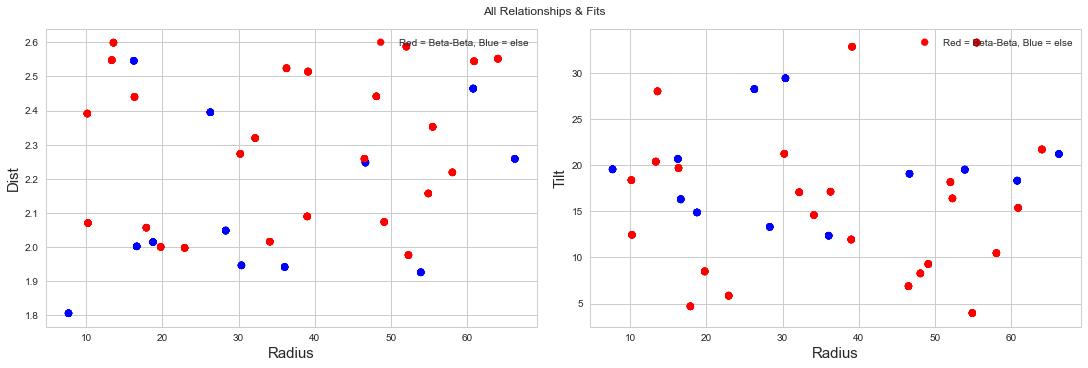

In [237]:
figsize = (15,5)
columns = 2
rows = 1

fig, ax = plt.subplots(rows, columns, figsize=figsize, constrained_layout=True)
fig.suptitle("All Relationships & Fits")

#Plot all Radius vs Distance
ax[0].scatter(h_bonds['radius'], h_bonds['dist'], c=colors)
ax[0].legend(['Red = Beta-Beta, Blue = else'], frameon=False, loc='upper right')
#ax[0].set_title(filename, fontsize=15)
ax[0].set_xlabel("Radius", fontsize=15)
ax[0].set_ylabel("Dist", fontsize=15)

#Plot all Radius vs Tilt
ax[1].scatter(h_bonds['radius'], h_bonds['tilt'], c=colors)
ax[1].legend(['Red = Beta-Beta, Blue = else'], frameon=False, loc='upper right')
#ax[1].set_title(filename, fontsize=15)
ax[1].set_xlabel("Radius", fontsize=15)
ax[1].set_ylabel("Tilt", fontsize=15)

plt.show() 

In [238]:
#figsize = (15,5)
#columns = 2
#rows = 1
#
#fig, ax = plt.subplots(rows, columns, figsize=figsize, constrained_layout=True)
#fig.suptitle("All Relationships & Fits")
#
##Plot Beta-Beta radius vs. dsitance w/ quadratic fit 
#[a, b, c] = np.polyfit(radius_onlyBB, dist_onlyBB, 2)
#x2d = np.linspace(0,50,100)
#y2d = a*(x2d**2) + b*x2d + c
#
#[a, b] = np.polyfit(radius_onlyBB, dist_onlyBB, 1)
#x1d = np.linspace(0,50,100)
#y1d = a*x1d + b
#
#ax[0].scatter(radius_onlyBB, dist_onlyBB, c=colors_onlyBB)
#ax[0].plot(x2d, y2d)
#ax[0].set_title(f'{filename} only Beta-Beta', fontsize=15)
#ax[0].set_xlabel("Radius", fontsize=15)
#ax[0].set_ylabel("Dist", fontsize=15)
#
##Plot Beta-Beta Radius vs Tilt w/ linear fit
#[a, b, c] = np.polyfit(radius_onlyBB, tilt_onlyBB, 2)
#x2d = np.linspace(0,50,100)
#y2d = a*(x2d**2) + b*x2d + c
#
#[a, b] = np.polyfit(radius_onlyBB, tilt_onlyBB, 1)
#x1d = np.linspace(0,50,100)
#y1d = a*x1d + b
#
#ax[1].scatter(radius_onlyBB, tilt_onlyBB, c=colors_onlyBB)
#ax[1].plot(x1d, y1d)
#ax[1].set_title(f'{filename} only Beta-Beta', fontsize=15)
#ax[1].set_xlabel("Radius", fontsize=15)
#ax[1].set_ylabel("Tilt", fontsize=15)
#
#plt.show() 

# Weighting linearly or with uncertainty

In [239]:
##Linear Weighting
#def linear_weight(radius):
#    return (1-(1/radius))
#
#dist_err = []
#for rad in radius_onlyBB:
#    dist_err.append(.0005*linear_weight(rad))
##derr = np.array(radius_onlyBB)*np.array(dist_err)
#
##Uncertainty
#derr = uncert_onlyBB

In [240]:
#def curve(x, a, b, c):
#    return a*(x**2) + b*x + c
#
#x = radius_onlyBB
#y = dist_onlyBB
#plt.errorbar(x, y, yerr=derr, fmt=".", label="Data")
#popt, pcov = sp.curve_fit(curve, x, y, sigma=derr)
#
#print("a =", popt[0], "+/-", pcov[0,0]**0.5)
#print("b =", popt[1], "+/-", pcov[1,1]**0.5)
#print("c =", popt[2], "+/-", pcov[2,2]**0.5)
#print('Weighted fit parameters:', popt)
#print('Covariance matrix:'); print(pcov)
#
#rangerad = np.linspace(0, 50)
#plt.plot(curve(rangerad, popt[0], popt[1], popt[2]), label="Fit")
#
#
##Graphics
#plt.title("Radius vs. H-bond Distance")
#plt.xlabel("Radius (angstroms)")
#plt.ylabel("H-bond Distance (angstroms)")
#plt.legend(loc='upper right')
##plt.savefig('/Users/NikosMynhier/Desktop/X_vs_lnI_Graph')
#plt.show()

# To Do
- for each line in hbond df append columns for the strucutre of the H residue and the O residue.
- color code each permutation of structures on either side of the H-bond, 4 options for H atom and 4 for O makes 16 potential structure relationship permutations.
- plot rad v dist with color, specifically look at if you see the positive exponential relationship david predicts with the b-sheet/b-sheet structure pair permutation.